## Server

###  Imports

In [1]:
from langchain_openai import ChatOpenAI

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from langgraph.graph.message import add_messages

from langchain_core.messages import (
    HumanMessage, 
    AIMessage, 
    SystemMessage,
    BaseMessage,
    trim_messages
)

from langchain_core.prompts import (
    ChatPromptTemplate, 
    MessagesPlaceholder,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate
)

from typing import Sequence

from typing_extensions import Annotated, TypedDict

import base64
from mimetypes import guess_type
import re
import os
import urllib

### Initialization

In [3]:
model = ChatOpenAI(model="gpt-4o")

### Data prep functions

In [4]:
trimmer = trim_messages(
    max_tokens=8,
    strategy="last",
    token_counter=len,
    include_system=True,
    allow_partial=False,
    # start_on="human",
)

In [5]:
def message_to_string(trimmings):
    n = 1
    result = ""
    for message in trimmings:
        result += "\n" + f"Instruction Number {n}:" + message.content
        n += 1
    result += "End of Instructioins you have given so far."
    return result

In [ ]:
# Example Scenarios with Continuous Thought (Variable Length and Edge Cases)
examples = [
    {
    "messages": [
    "The JetBot detected a tent wall with lights directly ahead and turned left sharply. [t90]",
    "The JetBot moved forward for 2 seconds through an opening to investigate objects of interest. [f2]",
    "The JetBot detected the dog in the center third of the screen but slightly to the right and turned left slightly to align. [t15]",
    "The JetBot overadjusted to the left, causing the dog to shift back slightly right toward the center. [t-10]",
    "The JetBot confirmed the dog is fully centered in the middle third of the screen. [t5]",
    "The JetBot moved forward to approach the dog and reached it. [f2]"
    ],
    "image_input": "The dog is fully centered in the middle third of the screen, with no smoke or obstacles.",
    "expected_response": "The dog is fully centered in the middle third of the screen, with no smoke or obstacles. Turning around to search for a new dog. [t180]<<d>>"
    },
    {
    "messages": [
    "The JetBot moved forward into a smoky environment. [f3]",
    "The JetBot detected the dog slightly off-center in the 1st quarter from the left of the screen and turned left sharply to align. [t30]",
    "The JetBot overcorrected, causing the dog to shift slightly right into the 2nd quarter. [t-15]",
    "The JetBot realigned, and the dog is now in the center-left of the screen. [t5]",
    "The JetBot moved forward and positioned itself directly in front of the dog. [f2]"
    ],
    "image_input": "The dog is now fully centered in the middle third of the screen.",
    "expected_response": "The dog is now fully centered in the middle third of the screen. Turning sharply to search for a new dog. [t180]<<d>>"
    },
    {
    "messages": [
    "The JetBot encountered an obstale covering the left half of its vision and turned right to avoid it. [t-45]",
    "The JetBot continued turning right to clear the obstacle. [t-15]",
    "The JetBot detected the dog in the 3rd quarter from the left of the screen and turned slightly right to align. [t-10]",
    "The JetBot adjusted its path and confirmed the dog is now in the center-left of the screen. [t5]",
    "The JetBot moved forward to approach the dog and stopped in front of it. [f1]"
    ],
    "image_input": "The dog is fully visible in the middle third of the screen.",
    "expected_response": "The dog is fully visible in the middle third of the screen. Turning around to begin searching for a new dog. [t180]<<d>>"
    },
    {
    "messages": [
    "The JetBot detected a tent wall lined with lights directly in front and turned right to avoid it. [t-60]",
    "The JetBot continued turning rigtt to avoid the same tent wall. [t-20]",
    "The JetBot moved forward explore further objects of interest. [f2]",
    "The JetBot detected the dog slightly off-center in the 2nd quarter from the left and turned left slightly to align. [t20]",
    "The JetBot overadjusted to the left, causing the dog to shift slightly back to the center. [t-10]",
    "The JetBot confirmed the dog is fully centered in the middle third of the screen and moved forward to reach it. [f3]"
    ],
    "image_input": "The dog is now fully centered in the middle third of the screen.",
    "expected_response": "The dog is now fully centered in the middle third of the screen. Turning sharply to search for a new dog. [t180]<<d>>"
    },
    {
    "messages": [
    "The JetBot detected an obstacle covering most of its right half of the screen and turned left to avoid it[t45]",
    "The JetBot detected the dog in the rightmost quarter of the screen and turned right slightly to align. [t-30]",
    "The JetBot overadjusted to the right and turned back slightly left to align better. [t15]",
    "The JetBot confirmed the dog is now centered in the middle-right of the screen and moved forward to stop in front of it. [f2]"
    "The JetBot continues to approach the dog is now centered in the middle left the screen and moved forward to stop in front of it. [f2]"

    ],
    "image_input": "The dog is visible in the middle of the screen, with no obstacles nearby.",
    "expected_response": "The dog is visible in the middle of the screen, with no obstacles nearby. Turning sharply to search for a new dog. [t180]<<d>>"
    },
    {
    "messages": [
    "The JetBot detected what appears to be a tent wall corner resembling plastic bags with lights and turned sharply to avoid it. [t90]",
    "The JetBot spots two obstacles to the far left and far right, so moved forward cautiously between two obstacles to explore further. [f2]",
    "The JetBot continues forward to search for objects of interest. [f2]",
    "The JetBot has gone too far forward and detected another tent wall right in front and covering the entire field of view and turned to stay within boundaries. [t90]",
    "The JetBot resumed forward motion after reorienting. [f1]"
    ],
    "image_input": "A tent wall resembling plastic bags with lights is visible directly ahead.",
    "expected_response": "A tent wall resembling plastic bags with lights is visible directly ahead. Turning sharply to avoid the boundary. [t180]"
    },
    {
    "messages": [
    "The JetBot moved forward into a smokey environment. [f1]",
    "The JetBot detected the dog slightly off-center in the 1st quarter from the left of the screen and turned left sharply to align. [t30]",
    "The JetBot comes to an obstacle covering the right side of the screen while navigating towards the dog and turns left to avoid it. [t30]"
    "The JetBot overcorrected, causing the dog to shift slightly right into the 2nd quarter. [t-15]",
    "The JetBot realigned, and the dog is now in the center-left of the screen. [t5]",
    "The JetBot moved forward and repositioned itself directly in front of the dog. [f2]"
    ],
    "image_input": "The dog is now fully centered in the middle third of the screen with a tent wall visible in the background.",
    "expected_response": "The dog is now confirmed to be fully centered in the middle third of the screen with a tent wall visible in the background. Turning sharply to search for a new dog. [t180]<<d>>"
    }
]

example_text = "\n".join(
    f"Example {i+1}:\n"
    f"Past Messages:\n" + "\n".join(f"  {msg}" for msg in example["messages"]) +
    f"\nImage Input:\n  {example['image_input']}\nExpected Response:\n  {example['expected_response']}\n"
    for i, example in enumerate(examples)
)

# print(example_text)

image_prompt_template = ChatPromptTemplate.from_messages(
    messages=[
        (
            "system",
            f"""You are a robot controller tasked with navigating a tiny robot, JetBot, to a purple figurine dog. 
            The JetBot receives image inputs and must reason about its environment and past actions to choose the best path forward. 
            The JetBot operates inside a tent and in a smoky environment, which may obscure visibility. 
            If the JetBot encounters obstacles (e.g., walls/edges of the tent, corners, or other objects), turn to avoid them. 
            The tent is blue and constructed of a gray tarp-like plastic material. The walls are lined with lights. 
            Always reason step-by-step and base your decisions on continuity from past actions.
            
            Here are examples of how you should reason and respond:
            {example_text}
            """
        ),
        # MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            """Now here are the actual instructions and reasoning you have given the Jetbot so far: {messages}
            First, summarize the instructions you have given so far sequentially. (Start with Instruction 1, If there are none, don't.). 
            Secondly, describe the following image. 
            (Hint: If there is a dog, describe its location and determine the direction the JetBot should travel to approach the dog. 
            Hint: If no dog is spotted in the image, analyze the environment. If the view is clear and no obstacles, objects or dogs can be seen, choose a different direction to continue exploring. IF YOU ARE HEADING DIRECTLY INTO THE WALLS OF THE PLASTIC TARP TENT AND IT IS RIGHT INFRONT OF YOU, you will collide so pick a different direction to turn to. If you see objects vaguely in the image, or items of interest, you should approach them to investigate. When the obstacles are DIRECTLY infront of you, you should navigate around them (if not, it's still safe to move forward if you think that direction is of interest). If the view is smokey, you could continue exploring said direction or find a different path if you are not getting results. 
            Hint: IF THE DOG IS RIGHT IN FRONT OF YOU AND YOU HAVE APPROACHED IT AND ARE CLOSE TO IT, Congratulations!! You have found the dog! But there are more to find! You should reason that since you have found the dog, you should explore other areas to find more dogs. In this case where you have ARRIVED at the dog, you MUST include the tag "<<d>>" in your response. This format is STRICT. If you include this tag "<<d>>" in your response, you should turn to avoid colliding into the dog, and search for dogs in other directions. Again, the dog should be DIRECTLY infront of you.)
            Finally, use prior instructions and outcomes to reason about the next move. Strictly format your response as:
            '<reasoning>. [<command><value>]'"""
        ),
        # MessagesPlaceholder(variable_name="messages"),
        # HumanMessagePromptTemplate.from_template(
        #     "Here is the image input: {image_url}"
        # ),
        HumanMessagePromptTemplate.from_template(
            [{'image_url': {'url': '{image_path}', 'detail': '{detail_parameter}'}}]
        )
    ]
)

# The prompt template now includes extended examples, reasoning continuity, and adherence to strict formatting.

In [8]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    detail_parameter: str
    image_path: str


workflow = StateGraph(state_schema=State)

def call_model(state: State):
    trimmed_messages = trimmer.invoke(state["messages"])
    prompt = image_prompt_template.invoke(
        {"messages": message_to_string(trimmed_messages), "detail_parameter": state["detail_parameter"], "image_path": state["image_path"]}
    )
    print(prompt)
    response = model.invoke(prompt)
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [9]:
config = {"configurable": {"thread_id": "abc456"}}

In [10]:
# # Function that calls llm model
# output = app.invoke(
#         {"detail_parameter": detail_parameter, "image_path": url},
#         config,
#     )
# output.messages[-1].content #returns this

In [11]:
# output = app.invoke(
#                 {"detail_parameter": detail_parameter, "image_path": url},
#                 config,
#             )
# print(output)

In [12]:
# import requests
# import os

# def save_image_from_url(url, folder_path, filename):
#     try:
#         # Send a GET request to the URL
#         response = requests.get(url, stream=True)
#         response.raise_for_status()  # Check if the request was successful
#         print("---------------------------------------------------------------------------------------------")
#         # Ensure the folder exists
#         os.makedirs(folder_path, exist_ok=True)

#         # Create the full file path
#         file_path = os.path.join(folder_path, filename)

#         # Save the image to the file
#         with open(file_path, 'wb') as file:
#             for chunk in response.iter_content(1024):
#                 file.write(chunk)

#         print(f"Image saved successfully to {file_path}")
#         return file_path
#     except Exception as e:
#         print(f"Error saving image: {e}")


In [13]:
import socket

class Server:
    def __init__(self, host, port):
        self.host = host
        self.port = port
        self.server_socket = None
        self.connection = None
        self.address = None

    def start(self):
        try:
            self.server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            self.server_socket.bind((self.host, self.port))
            self.server_socket.listen(1)
            print(f"Server listening on {self.host}:{self.port}")
        except Exception as e:
            print(f"Error starting server: {e}")

    def accept_connection(self):
        try:
            self.connection, self.address = self.server_socket.accept()
            print(f"Connected by {self.address}")
        except Exception as e:
            print(f"Error accepting connection: {e}")

    def receive(self):
        try:
            if self.connection:
                data = ""
                while True:
                    chunk = self.connection.recv(1024)
                    if not chunk:  # Connection closed by client
                        break
                    data += chunk.decode()

                    # Check if the last two characters are ==
                    if data.endswith("<END>"):
                        data = data.replace("<END>", "")
                        break

                print(f"Received from client: {data}")
                return data
            else:
                print("No active connection.")
        except Exception as e:
            print(f"Error receiving data: {e}")


    def send(self, message):
        try:
            if self.connection:
                message_bytes = message.encode()  # Convert to bytes
                total_sent = 0
                while total_sent < len(message_bytes):
                    sent = self.connection.send(message_bytes[total_sent:])
                    if sent == 0:
                        raise RuntimeError("Socket connection broken.")
                    total_sent += sent
                print(f"Sent to client: {message}")
            else:
                print("No active connection to send data.")
        except Exception as e:
            print(f"Error sending message: {e}")


    def close_connection(self):
        try:
            if self.connection:
                self.connection.close()
                print("Connection with client closed.")
                self.connection = None
            else:
                print("No active connection to close.")
        except Exception as e:
            print(f"Error closing connection: {e}")

    def stop(self):
        try:
            if self.server_socket:
                self.server_socket.close()
                print("Server stopped.")
            else:
                print("Server is not running.")
        except Exception as e:
            print(f"Error stopping server: {e}")

In [14]:
def contains_found_dog(input_string, dog_count):
    # Use regex to search for the specific string "<found_dog>"
    pattern = r"<<d>>"
    found = bool(re.search(pattern, input_string))
    if found:
        return dog_count
    else:
        return -1

In [15]:
server = Server("206.87.203.235", 5175)
server.start()
server.accept_connection()
def loop():
    try:
        dog_count = 0
        detail_parameter = 'high'
        while True:
            url = server.receive()
            print("NOTICE: Received URL")
            output = app.invoke(
                {"detail_parameter": detail_parameter, "image_path": url},
                config,
            )
            print("NOTICE: Got Model output")
            string_output = output["messages"][-1].content
            print("NOTICE: Got model formatted output")
            found_results = contains_found_dog(string_output, dog_count)
            if found_results >= 0:
                testfile = urllib.URLopener()
                testfile.retrieve(url, f"images/{found_results+1}.jpeg")
                dog_count += 1
                print("NOTICE: Found and saved dog")
            server.send(string_output)
            print("NOTICE: Sent string to client")
    except Exception as e:
        print("Error during communication: {}".format(e))
    finally:
        server.close_connection()
        print("Connection closed.")


Server listening on 206.87.203.235:5175
Connected by ('206.87.205.3', 36154)


Received from client: 
NOTICE: Received URL
messages=[SystemMessage(content='You are a robot controller tasked with navigating a tiny robot, JetBot, to a purple figurine dog. \n            The JetBot receives image inputs and must reason about its environment and past actions to choose the best path forward. \n            The JetBot operates inside a tent and in a smoky environment, which may obscure visibility. \n            If the JetBot encounters obstacles (e.g., walls/edges of the tent, corners, or other objects), turn to avoid them. \n            The tent is blue and constructed of a gray tarp-like plastic material. The walls are lined with lights. \n            Always reason step-by-step and base your decisions on continuity from past actions.\n            \n            Here are examples of how you should reason and respond:\n            Example 1:\nPast Messages:\n  The JetBot detected a wall directly ahead and turned left sharply. [t90]\n  The JetBot moved forward for 2 second
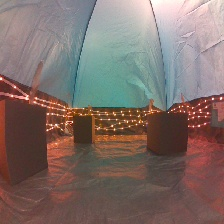
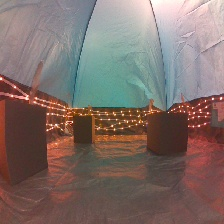
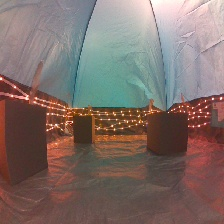
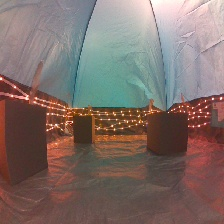
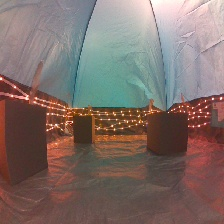
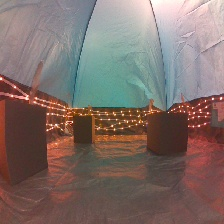
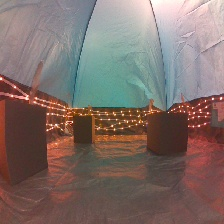
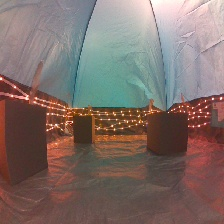
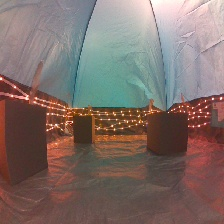
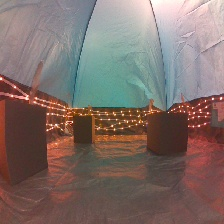
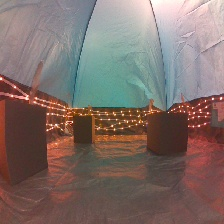
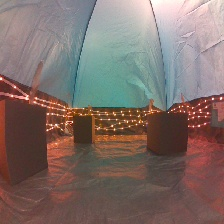
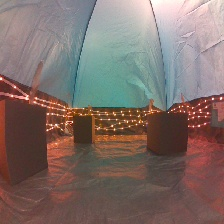
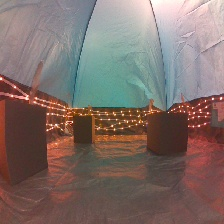
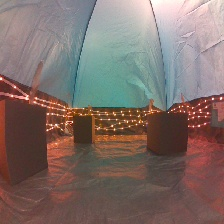
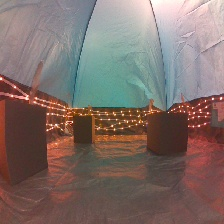
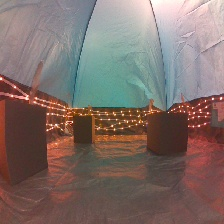
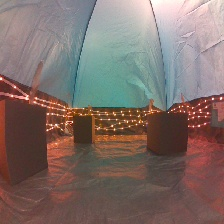
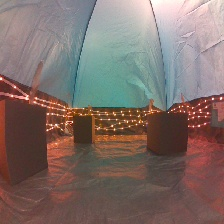
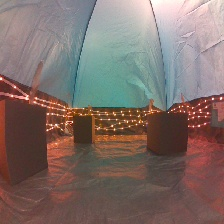
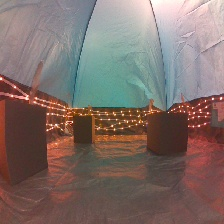
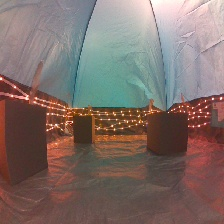
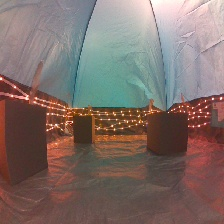
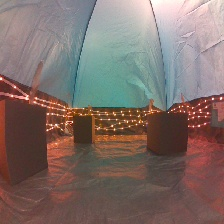
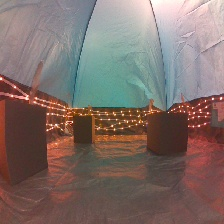
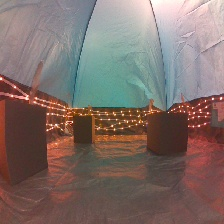
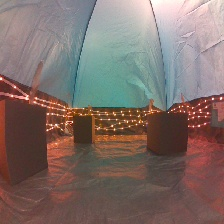
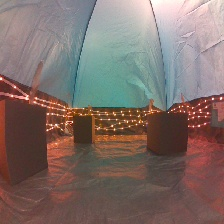
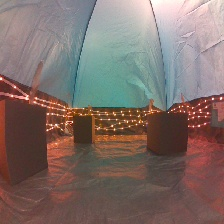
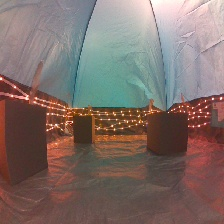
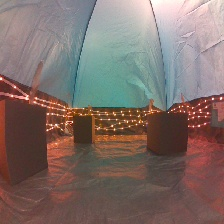
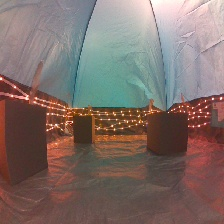
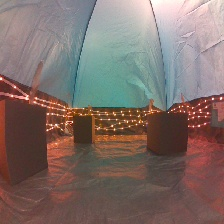
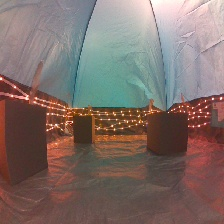
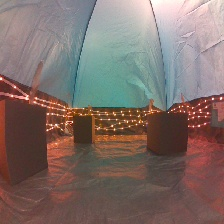
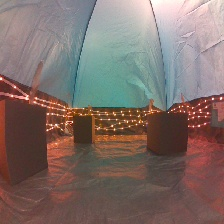
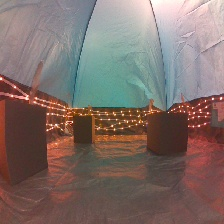
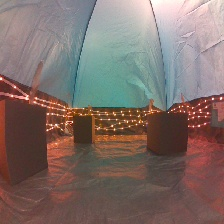
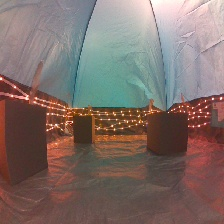
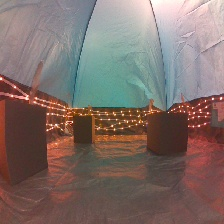
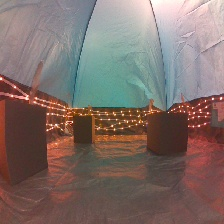
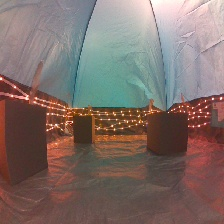
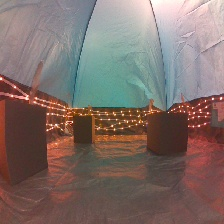
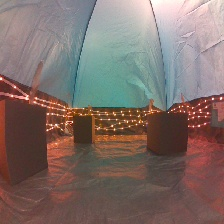
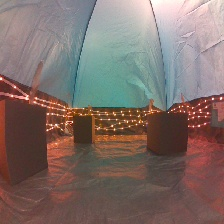
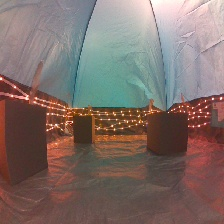
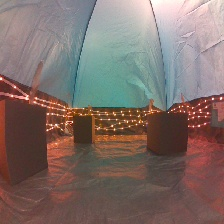
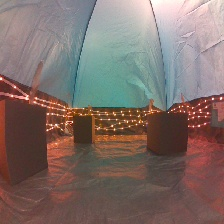
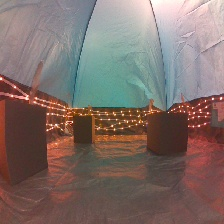
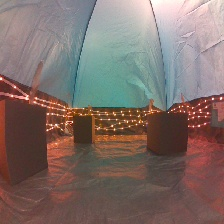
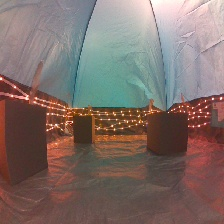
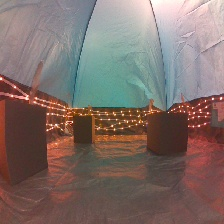
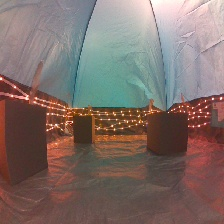
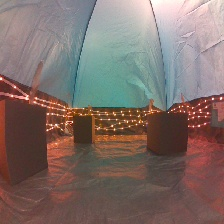
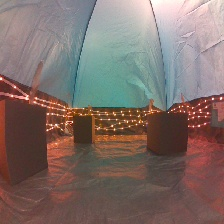
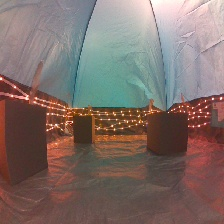

In [16]:
loop()

In [31]:
server.close_connection()

No active connection to close.
